In [ ]:
from audiomentations.core.transforms_interface import BaseWaveformTransform
from numpy.typing import NDArray
import random
import numpy as np
from audiomentations.core.utils import calculate_rms
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import torchaudio.transforms as T
from audiomentations import (
    AddGaussianNoise,
    AddGaussianSNR,
    Gain,
    GainTransition,
    HighPassFilter,
    LowPassFilter,
    BandPassFilter,
    BandStopFilter,
    ClippingDistortion,
    Clip,
    Normalize,
    PitchShift,
    PolarityInversion,
    Resample,
    Reverse,
    Shift,
    TanhDistortion,
    TimeMask,
    TimeStretch,
    Trim,
    Limiter,
    Mp3Compression,
    Compose

)
import os
os.chdir('..')
print(os.getcwd())

FILE_NAME = './datasets/UAV_Dataset_31/DJI_Tello/DJI_Tello_2.wav'
# FILE_NAME = 'Users/Sidewinders/Desktop/CODE/UAV_Classification_repo/src/datasets/UAV_Dataset_31/DJI_Tello/DJI_Tello_77.wav'

def load_wav(path):
    waveform, sample_rate = torchaudio.load(path)
    return waveform.numpy(), sample_rate

def plot_waveforms_comparison(original_audio, augmented_audio, sr, title1="Original", title2="Augmented", color1='blue', color2='red'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Calculate the maximum amplitude across both audio signals
    max_amplitude = max(np.max(np.abs(original_audio)), np.max(np.abs(augmented_audio)))

    # Plot original audio
    librosa.display.waveshow(original_audio, sr=sr, ax=ax1, color=color1)
    ax1.set_title(title1)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_ylim(-max_amplitude, max_amplitude)

    # Plot augmented audio
    librosa.display.waveshow(augmented_audio, sr=sr, ax=ax2, color=color2)
    ax2.set_title(title2)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Amplitude')
    ax2.set_ylim(-max_amplitude, max_amplitude)

    plt.tight_layout()
    plt.show()

def plot_waveforms_overlay(original_audio, augmented_audio, sr, title="Original vs Augmented"):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Calculate the maximum amplitude across both audio signals
    max_amplitude = max(np.max(np.abs(original_audio)), np.max(np.abs(augmented_audio)))

    # Plot original audio
    librosa.display.waveshow(original_audio, sr=sr, ax=ax, color='blue', alpha=0.7, label='Original')

    # Plot augmented audio
    librosa.display.waveshow(augmented_audio, sr=sr, ax=ax, color='red', alpha=0.5, label='Augmented')

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(-max_amplitude, max_amplitude)
    ax.legend()

    plt.tight_layout()
    plt.show()

def apply_and_visualize_transform(transform, file_name=FILE_NAME):
    # Load audio and sample rate (sr) and display
    audio, sr = load_wav(file_name)
    print("Original Audio:")
    display(ipd.Audio(audio, rate=sr))


    # Transform audio and display
    augmented_audio = transform(audio, sample_rate=int(sr))
    print("Augmented Audio:")
    display(ipd.Audio(augmented_audio, rate=sr))

    # Cross correlate audio samples
    max_corr, lag = cross_correlation(audio, augmented_audio)

    print(f"Maximum correlation: {max_corr:.4f}")
    print(f"Lag: {lag} samples")
    print(f"Lag Time: {lag/sr:.4f} seconds")

    # Plot the two .wav samples
    plot_waveforms_comparison(audio, augmented_audio, sr, color1='navy', color2='darkred')

    # Plot the overlay comparison
    plot_waveforms_overlay(audio, augmented_audio, sr)

    return audio, augmented_audio, sr

def cross_correlation(audio1, audio2):
    """
    Compute the cross-correlation between two audio signals.

    :param audio1: First audio signal (numpy array)
    :param audio2: Second audio signal (numpy array)
    :return: Maximum correlation value and the corresponding lag
    """
    # Ensure both arrays are 1D
    audio1 = audio1.flatten()
    audio2 = audio2.flatten()

    # Compute cross-correlation
    correlation = np.correlate(audio1, audio2, mode='full')

    # Find the index of maximum correlation
    max_corr_index = np.argmax(np.abs(correlation))

    # Calculate the lag
    lag = max_corr_index - (len(audio1) - 1)

    # Normalize the maximum correlation value
    max_corr_value = correlation[max_corr_index] / (np.linalg.norm(audio1) * np.linalg.norm(audio2))

    return max_corr_value, lag




class SinDistortion(BaseWaveformTransform):

    supports_multichannel = True

    def __init__(
        self, min_distortion: float = 0.01, max_distortion: float = 0.7, p: float = 0.5
    ):
        """
        :param min_distortion: Minimum amount of distortion (between 0 and 1)
        :param max_distortion: Maximum amount of distortion (between 0 and 1)
        :param p: The probability of applying this transform
        """
        super().__init__(p)
        assert 0 <= min_distortion <= 1
        assert 0 <= max_distortion <= 1
        assert min_distortion <= max_distortion
        self.min_distortion = min_distortion
        self.max_distortion = max_distortion

    def randomize_parameters(self, samples: NDArray[np.float32], sample_rate: int):
        super().randomize_parameters(samples, sample_rate)
        if self.parameters["should_apply"]:
            self.parameters["distortion_amount"] = random.uniform(
                self.min_distortion, self.max_distortion
            )

    def apply(self, samples: NDArray[np.float32], sample_rate: int) -> NDArray[np.float32]:
        # Find out how much to pre-gain the audio to get a given amount of distortion
        percentile = 100 - 99 * self.parameters["distortion_amount"]
        threshold = np.percentile(np.abs(samples), percentile)
        gain_factor = 0.5 / (threshold + 1e-6)

        # Distort the audio
        distorted_samples = np.sin(gain_factor * samples)

        # Scale the output so its loudness matches the input
        rms_before = calculate_rms(samples)
        if rms_before > 1e-9:
            rms_after = calculate_rms(distorted_samples)
            post_gain = rms_before / rms_after
            distorted_samples = post_gain * distorted_samples

        return distorted_samples

c:\Users\Sidewinders\Desktop\CODE\UAV_Classification_repo\src
Original Audio:


Augmented Audio:


Maximum correlation: 0.6471
Lag: -84017 samples
Lag Time: -1.9051 seconds


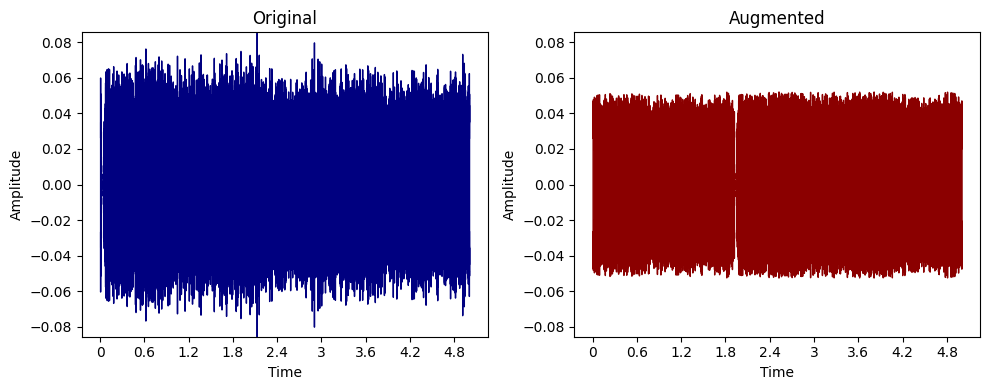

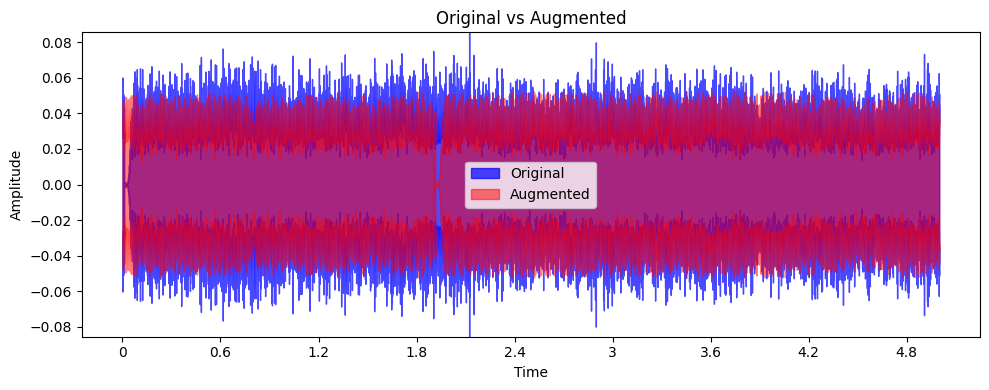

In [ ]:

transforms =[]
transforms.append(Shift(
    min_shift=1.0,
    max_shift=2.0,
    shift_unit="seconds",
    rollover=True,
    fade_duration= 0.01,
    p = 1.0
))


transforms.append(SinDistortion(
    min_distortion=0.1,
    max_distortion=0.6,
    p=1.0
))

transform = Compose(transforms)
audio, augmented_audio, sr = apply_and_visualize_transform(transform)


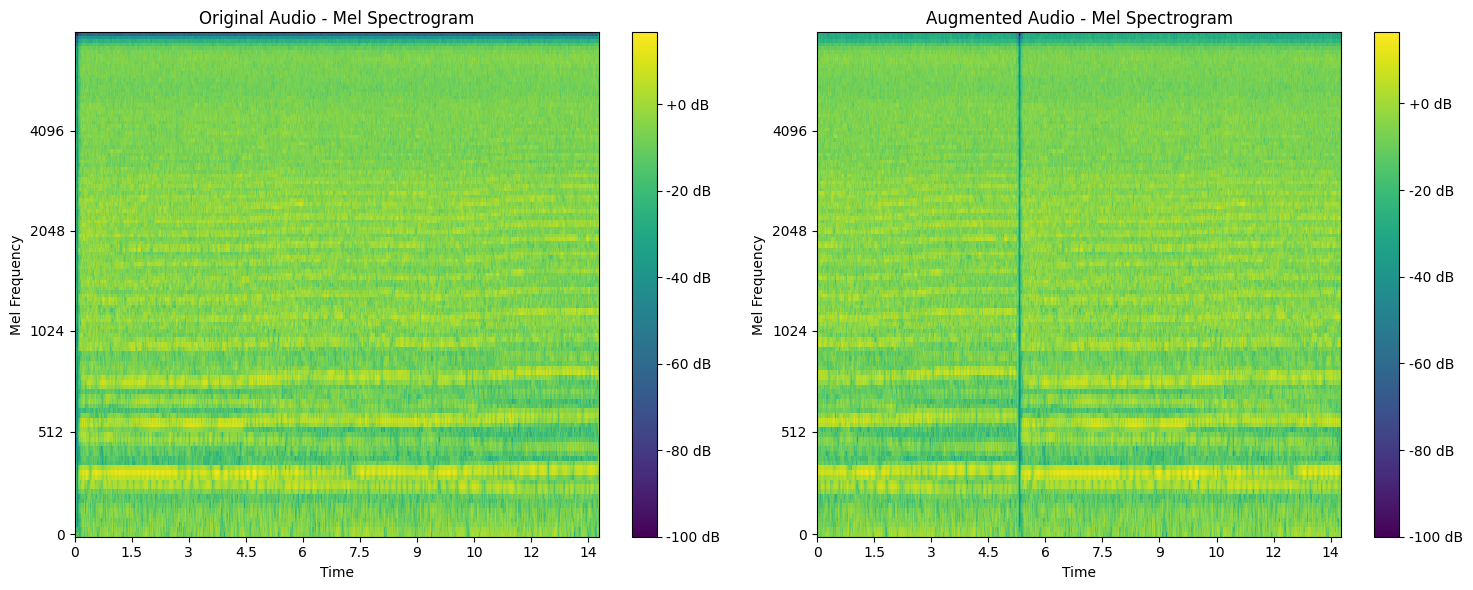

Original mel spectrogram shape: torch.Size([1, 128, 1723])
Augmented mel spectrogram shape: torch.Size([1, 128, 1723])
Original mel spectrogram range: -100.00 to 16.63 dB
Augmented mel spectrogram range: -100.00 to 16.43 dB


In [18]:
from librosa.feature import melspectrogram  
import torch

# take augmented audio and audio and feature extract them and plot them side by side

# feature extract the audio
# Using parameters from config.yaml
sampling_rate = 16000
n_fft = 1024
hop_length = 128
n_mels = 128
power = 2

# Create melspectrogram transform
mel_transform = T.MelSpectrogram(
    sample_rate=sampling_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    power=power
)

# Convert audio arrays to tensors and ensure they're the right shape
original_tensor = torch.FloatTensor(audio).unsqueeze(0) if audio.ndim == 1 else torch.FloatTensor(audio)
augmented_tensor = torch.FloatTensor(augmented_audio).unsqueeze(0) if augmented_audio.ndim == 1 else torch.FloatTensor(augmented_audio)

# Apply mel transform
original_mel = mel_transform(original_tensor)
augmented_mel = mel_transform(augmented_tensor)

# Convert to dB scale for better visualization
original_mel_db = T.AmplitudeToDB()(original_mel)
augmented_mel_db = T.AmplitudeToDB()(augmented_mel)

# Plot side by side melspectrograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original melspectrogram
im1 = librosa.display.specshow(original_mel_db.squeeze().numpy(), 
                              sr=sampling_rate, 
                              hop_length=hop_length,
                              x_axis='time', 
                              y_axis='mel', 
                              ax=ax1,
                              cmap='viridis')
ax1.set_title('Original Audio - Mel Spectrogram')
ax1.set_xlabel('Time')
ax1.set_ylabel('Mel Frequency')

# Augmented melspectrogram
im2 = librosa.display.specshow(augmented_mel_db.squeeze().numpy(), 
                              sr=sampling_rate, 
                              hop_length=hop_length,
                              x_axis='time', 
                              y_axis='mel', 
                              ax=ax2,
                              cmap='viridis')
ax2.set_title('Augmented Audio - Mel Spectrogram')
ax2.set_xlabel('Time')
ax2.set_ylabel('Mel Frequency')

# Add colorbars
plt.colorbar(im1, ax=ax1, format='%+2.0f dB')
plt.colorbar(im2, ax=ax2, format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Print some statistics about the spectrograms
print(f"Original mel spectrogram shape: {original_mel.shape}")
print(f"Augmented mel spectrogram shape: {augmented_mel.shape}")
print(f"Original mel spectrogram range: {original_mel_db.min():.2f} to {original_mel_db.max():.2f} dB")
print(f"Augmented mel spectrogram range: {augmented_mel_db.min():.2f} to {augmented_mel_db.max():.2f} dB")


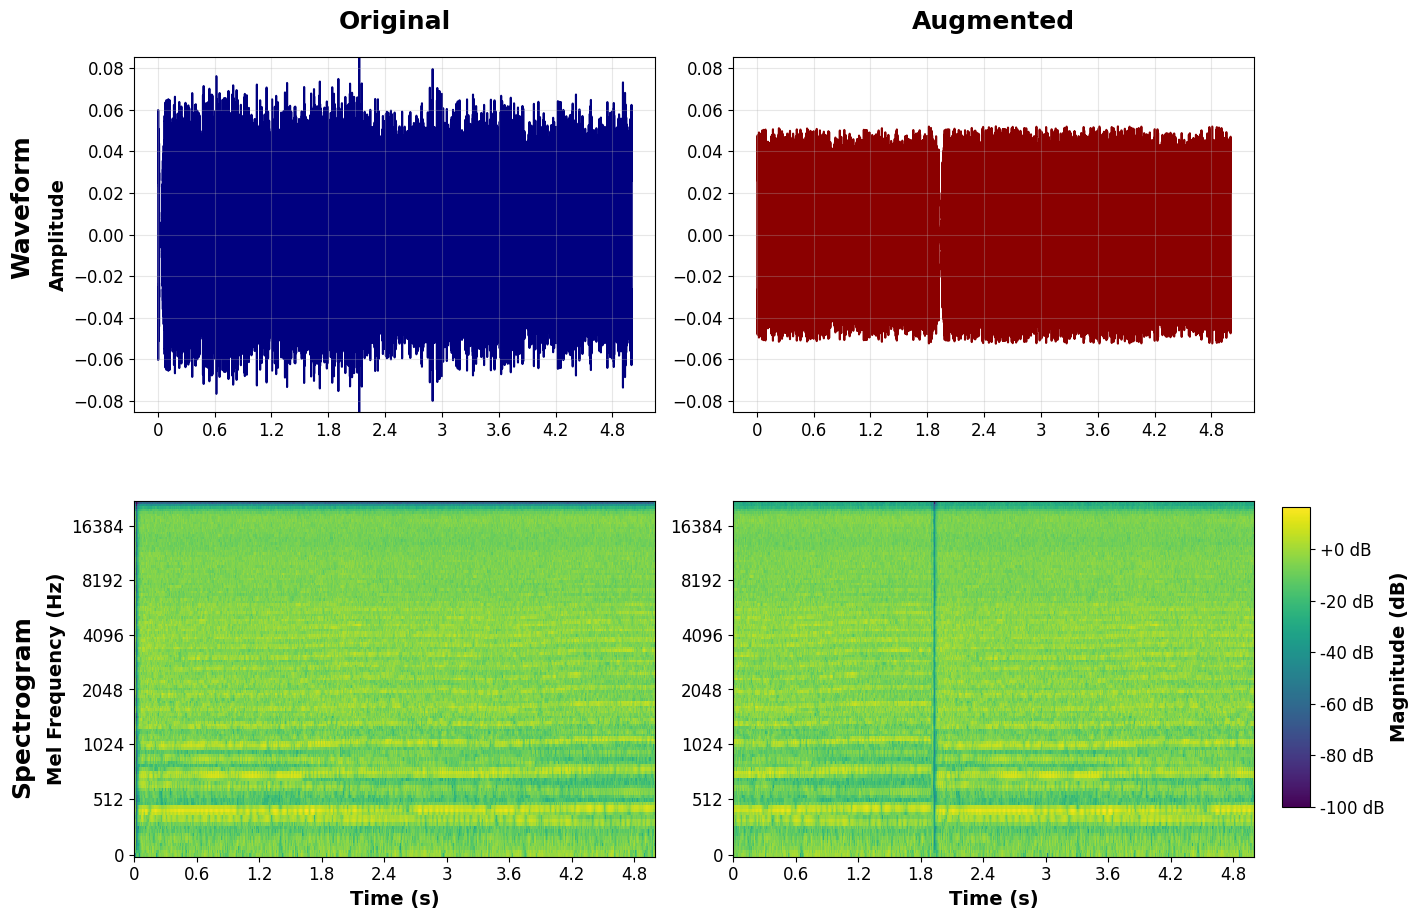

In [32]:
def plot_matrix_style_comparison(original_audio, augmented_audio, sr, 
                                original_mel_db, augmented_mel_db, 
                                hop_length=128, figsize=(14, 10)):
    """
    Create a confusion matrix style 2x2 comparison plot with shared axis labels.
    Columns: Original vs Augmented
    Rows: Waveform vs Spectrogram
    """
    # Set up the figure and subplots with shared labels
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Set large font sizes for better readability
    plt.rcParams.update({'font.size': 14})
    
    # Calculate max amplitude for consistent y-axis scaling
    max_amplitude = max(np.max(np.abs(original_audio)), np.max(np.abs(augmented_audio)))
    
    # Row 1: Waveforms
    # Original waveform (top-left)
    librosa.display.waveshow(original_audio, sr=sr, ax=axes[0,0], color='navy', linewidth=1.5)
    axes[0,0].set_ylabel('Amplitude', fontsize=14, fontweight='bold')
    axes[0,0].set_ylim(-max_amplitude, max_amplitude)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(labelsize=12)
    axes[0,0].set_xlabel('')  # Remove individual x-label
    
    # Augmented waveform (top-right)
    librosa.display.waveshow(augmented_audio, sr=sr, ax=axes[0,1], color='darkred', linewidth=1.5)
    axes[0,1].set_ylim(-max_amplitude, max_amplitude)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(labelsize=12)
    axes[0,1].set_ylabel('')  # Remove individual y-label
    axes[0,1].set_xlabel('')  # Remove individual x-label
    
    # Row 2: Spectrograms
    # Original spectrogram (bottom-left)
    im1 = librosa.display.specshow(original_mel_db.squeeze().numpy(), 
                                  sr=sr, 
                                  hop_length=hop_length,
                                  x_axis='time', 
                                  y_axis='mel', 
                                  ax=axes[1,0],
                                  cmap='viridis')
    axes[1,0].set_ylabel('Mel Frequency (Hz)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Time (s)', fontsize=14, fontweight='bold')
    axes[1,0].tick_params(labelsize=12)
    
    # Augmented spectrogram (bottom-right)
    im2 = librosa.display.specshow(augmented_mel_db.squeeze().numpy(), 
                                  sr=sr, 
                                  hop_length=hop_length,
                                  x_axis='time', 
                                  y_axis='mel', 
                                  ax=axes[1,1],
                                  cmap='viridis')
    axes[1,1].set_xlabel('Time (s)', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('')  # Remove individual y-label
    axes[1,1].tick_params(labelsize=12)
    
    # Add column headers (like confusion matrix)
    axes[0,0].set_title('Original', fontsize=18, fontweight='bold', pad=20)
    axes[0,1].set_title('Augmented', fontsize=18, fontweight='bold', pad=20)
    
    # Add row labels on the left (like confusion matrix)
    fig.text(0.02, 0.75, 'Waveform', fontsize=18, fontweight='bold', 
             rotation=90, va='center', ha='center')
    fig.text(0.02, 0.25, 'Spectrogram', fontsize=18, fontweight='bold', 
             rotation=90, va='center', ha='center')
    
    # Add separator lines to distinguish row labels from plots
    # Vertical line separating row labels from plots
    # Vertical line separating row labels from plots
    # fig.add_artist(plt.Line2D([0.02, 0.02], [0.1, 0.9], color='black', linewidth=2, alpha=0.7, transform=fig.transFigure, clip_on=False))
    # # Horizontal line separating waveform and spectrogram rows
    # fig.add_artist(plt.Line2D([0.08, 0.92], [0.5, 0.5], color='black', linewidth=2, alpha=0.7, transform=fig.transFigure, clip_on=False))
    
    # Add a single colorbar for spectrograms
    # Position it between the two spectrogram plots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.3])  # [left, bottom, width, height]
    cbar = fig.colorbar(im2, cax=cbar_ax, format='%+2.0f dB')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Magnitude (dB)', fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, 
                       wspace=0.15, hspace=0.25)
    
    plt.show()

# Create the matrix-style comparison plot
plot_matrix_style_comparison(audio, augmented_audio, sr, 
                           original_mel_db, augmented_mel_db, 
                           hop_length=hop_length)
